## warehouse collision 해결하고 warehouse에 코드로 넣기

### deadend 해결을 heuristic map으로 구현한다면, navigate 설정을 조금 바꿔야 함 (어렵지 않음)

In [1]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import copy
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [2]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

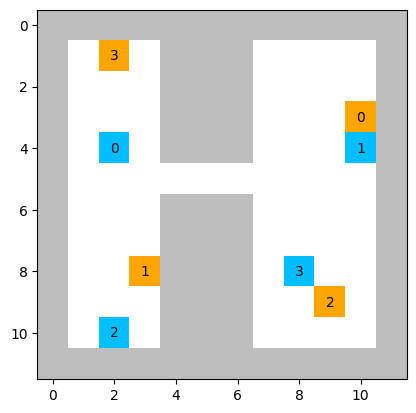

In [3]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), np.array([[4, 2], [4, 10], [10, 2], [8, 8]]), np.array([[3, 10], [8, 3], [9, 9], [1, 2]]))
num_agents = len(toy[1])
map_width = len(toy[0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [5]:
env.observe()[1][0]

array([4, 2])

In [10]:
class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
    
  def negotiator(self):
    return Agent(
      role='Negotiator',
      goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
      backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
      """,
      verbose=True,
    )
	
class PathFindingTasks():
  def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV):
    return Task(
      description=(
        f"""
        Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
        East and west in the coordinates correspond to the x axis.
        South and north in the coordinates correspond to the y axis.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        Below is your field of view, the centre is your current position, 0 is unobstructed space, and 1 is obstructed space.
        {agent_FOV}
        {east}
        {west}
        {south}
        {north}
        {last_action}
        Below is a list of the coordinates you visited.
        {coordinates}
        If you keep hovering over coordinates you've already visited, you're in a dead end, and it is recommended that you use the right-hand rule.
        The right-hand rule refers to the rule of navigating a maze with the wall in your right hand.
        Which direction do you move next?

        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
    
  def negotiate(self, agent):
    return Task(
      description=(
        f"""
        Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.
        The planned moves of each agent represent the previous outcomes.
        """
      ),
      expected_output='Direction of the agents',
      agent=agent
    )
  
  def give_way(self, agent, east, west, north, south, direction):
    return Task(
      description=(
        f"""
        You MUST avoid collisions with prior path finder.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        To the {direction} of you is prior path finder.
        Which direction do you move next?
        I highly recommend going to the 90-degree turn rather than the other side of the pathfinder, but you can ignore this instruction depending on your situation.
        
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )

agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]
negotiator = agents.negotiator()

ValidationError: 1 validation error for ChatOpenAI
__root__
  Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass `openai_api_key` as a named parameter. (type=value_error)

In [5]:
#에이전트들의 지난번 액션들과 좌표
action_list = [[] for _ in range(num_agents)]
coordinate_list = [[] for _ in range(num_agents)]



> Entering new CrewAgentExecutor chain...


2024-07-10 15:16:22,548 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates and the destination coordinates, it seems logical to move eastward, as it will bring me closer to my destination. Moreover, my field of view indicates that there is a path available to the east. I must also ensure that I don't enter a loop by visiting the same coordinates repeatedly, and for that, I will use the right-hand rule if necessary.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-07-10 15:16:27,918 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the field of view, I see the wall is to my east and I have a clear path to the west, south, and north. Given that I need to move from (10,7) to (3,3), it's clear that I need to move towards the west and south to get closer to my destination. Since I am in a maze, I will follow the right-hand rule for navigation. This means I will keep the wall to my right side and move in the direction where the wall turns. In this case, the wall is on my east, so I will turn south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-07-10 15:16:34,245 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the current coordinates and the destination, I need to move in a northeasterly direction. However, since I can only move in one direction at a time, I would prioritize moving in a direction that gets me closer to the destination coordinates. My current coordinates are (2,1) and I need to get to (9,2). This means I need to move primarily east to increase my x-coordinate. My path to the east is unobstructed.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current coordinates (8,3) and my destination (2,10), I need to move northwards and westwards. However, I need to be careful of any obstructions in my path. According to the field of view, there are no obstructions in any direction. Since my destination is more in the north direction than the west, I should prioritize moving north. Therefore, my next move should be north.

Final Answer: North

> Finished chain.


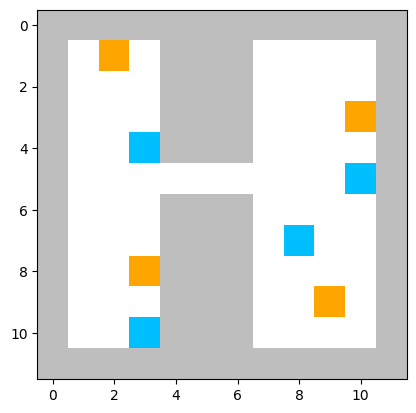

2024-07-10 15:16:39,090 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-07-10 15:16:42,197 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and the layout of the map, it seems that the best course of action would be to continue moving North as the East is blocked by a wall, and I came from the West. Moving South would lead me back to a previous position which does not seem productive given the goal is to reach the destination at (10,8).

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-07-10 15:16:46,507 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the layout of the field, the only logical direction to move would be north as east and south are blocked by a wall and west is the direction I came from. Following the right-hand rule, I should keep the wall on my right, which also points to moving north. I must also remember that I should not revisit the coordinates I've already been to, to avoid being caught in a dead end.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-07-10 15:16:50,703 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position (10,6) and knowing I need to reach (3,3), I see that I need to move both south (decrease in y-coordinate) and west (decrease in x-coordinate). As my east is blocked and I just came from north, I can either move west or south. However, I've already visited the coordinate to the south (10,7), so to avoid retracing my steps, I should move west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given my current position (8,4) and the destination (2,10), it is clear that I need to move north and west. However, I need to avoid visiting the same coordinates again. Taking into consideration the right-hand rule, I'll need to choose a direction that doesn't lead me back to previously visited coordinates and allows me to move closer to my goal. 

Final Answer: North

> Finished chain.


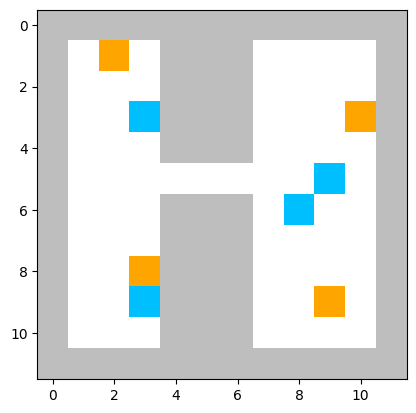

2024-07-10 15:16:55,110 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-07-10 15:16:59,777 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (3,8) and the goal position (10,8), I need to move eastwards. However, my east is blocked by a wall. The right-hand rule suggests that I should keep the wall to my right, which would lead me to move south, but considering I came from the south, moving back there could lead to a loop. So, the best option left is to move north and find a potential passageway on that side. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-07-10 15:17:04,043 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position and the field of view, I can see that I'm near a wall to the east and there are unobstructed paths to the north, south, and west. Since I came from the south and I don't want to backtrack, and considering that the right-hand rule recommends that I keep the wall on my right, the best option seems to be to move north.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-07-10 15:17:08,560 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (9,6) and my goal is to reach (3,3), I need to move towards the west and south. However, I just came from the east and to avoid retracing my steps, I should follow the right-hand rule. This rule suggests that I should keep the wall to my right, which would lead me towards the south. Additionally, the field of view shows an unobstructed path in all directions, including south. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current location (8,5) and my destination (2,10), I need to move northwards and westwards. However, I see from the map that all directions are currently open for me to move. Since I have just come from the south, and considering the right-hand rule, my next move should be to the west. 

Final Answer: West

> Finished chain.


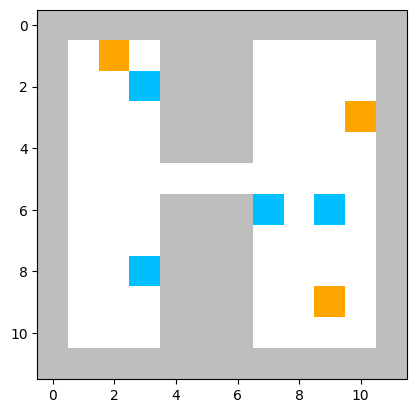

2024-07-10 15:17:12,583 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-07-10 15:17:16,418 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that I came from the South and my East is blocked, following the right-hand rule, I should move towards the North. Also, I have not yet visited that coordinate which could potentially lead me closer to my destination (10,8). Furthermore, this aligns with my goal of avoiding areas I've already visited.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-07-10 15:17:20,826 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (3,3) and the destination (9,2), along with the fact that there is an obstructed path to the east, I will need to find an alternative route. Since I came from the south, and I have already visited the coordinates to the south and the west, the logical choice is to move north to avoid getting trapped in a dead end. Also, following the right-hand rule of navigation, since the east is blocked, moving north is the next best option. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-07-10 15:17:24,836 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position, I can see that moving in any direction is possible. However, my destination is towards the south-west from my current position. Therefore, it would be most efficient to move in a direction that brings me closer to my destination. Since I came from the north, and I have not visited the south or west yet, I will choose to move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current position and the unobstructed paths available, the best direction to move next would be North. This is because I have come from the East and the West is blocked, and moving South would lead me back to a location I have already visited. Furthermore, since my destination coordinates are higher on the y-axis than my current position, moving North is in line with my destination.

Final Answer: North

> Finished chain.


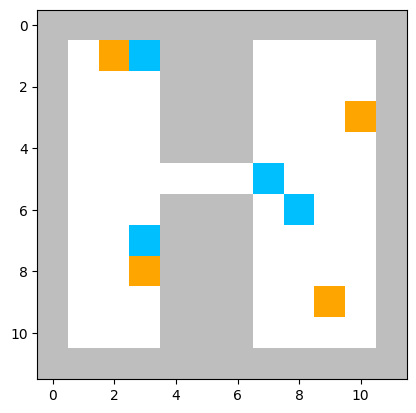

2024-07-10 15:17:30,241 - 32140 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


KeyboardInterrupt: 

In [6]:
# 20 turn
for n in range(10):

  for i in range(num_agents):
     x_coordinate = env.observe()[1][i][1]
     y_coordinate = map_width-env.observe()[1][i][0]
     coordinate_list[i].append([x_coordinate, y_coordinate])

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_sets = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_sets for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      coordinates = f"""{coordinate_list[i]}"""

      agent_FOV = '\n'.join(' '.join(map(str, row)) for row in env.observe()[0][i][1][2:7, 2:7])

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      if result not in directiondict:
        result = 'stay'

      action_list[i].append(result)
    
      step[i] = directiondict[result]
  
  # 교착상태에 빠진 에이전트에 대해
  for connected_set in connected_sets:
    
    results = []

    for i in connected_set: # 여기서 i는 agent의 번호들
    
    #각각의 에이전트에 대해 원래 계획된 경로를 계산

      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      coordinates = f"""{coordinate_list[i]}"""

      agent_FOV = '\n'.join(' '.join(map(str, row)) for row in env.observe()[0][i][1][2:7, 2:7])

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action, coordinates, agent_FOV)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      if result not in directiondict:
        result = 'stay'

      results.append(result)

    env_copy = copy.deepcopy(env)
    planned_step = [0 for _ in range(num_agents)]
    for idx, agent_idx in enumerate(connected_set):
      planned_step[agent_idx] = directiondict[results[idx]]
    if -0.5 in env_copy.step(planned_step)[1]:
      collision = True
    else:
      collision = False

    if not collision:
      for idx, agent_idx in enumerate(connected_set):
        action_list[agent_idx].append(results[idx])
        step[agent_idx] = directiondict[results[idx]]
# 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
# 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
    else:
    # 먼저 prior agent는 원래대로 이동하게 함
      prior_agent_number = max(connected_set)
      prior_agent_idx = connected_set.index(prior_agent_number)
      action_list[prior_agent_number].append(results[prior_agent_idx])
      step[prior_agent_number] = directiondict[results[prior_agent_idx]]
      for i in connected_set:
        if i != prior_agent_number:
            a_obs = env.observe()[0][i][1]
            x = env.observe()[1][i][1]
            y = map_width-env.observe()[1][i][0]
            x_finish = toy[2][i][1]
            y_finish = map_width-toy[2][i][0]

            if a_obs[4][3] == 0:
                west = """To your west lies a path."""
            else:
                west = """Your west is blocked by a wall."""

            if a_obs[4][5] == 0:
                east = """To your east lies a path."""
            else:
                east = """Your east is blocked by a wall."""

            if a_obs[5][4] == 0:
                south = """To your south lies a path."""
            else:
                south = """Your south is blocked by a wall."""

            if a_obs[3][4] == 0:
                north = """To your north lies a path."""
            else:
                north = """Your north is blocked by a wall."""

            # prior agent의 direction 구하기
            agent_map = env.observe()[0][i][0][2:7, 2:7]
            center = (2, 2)
            max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

            row_diff = center[0] - max_position[0]
            col_diff = center[1] - max_position[1]

            if row_diff > 0 and col_diff > 0:
                direction = "northwest"
            elif row_diff > 0 and col_diff == 0:
                direction = "north"
            elif row_diff > 0 and col_diff < 0:
                direction = "northeast"
            elif row_diff == 0 and col_diff > 0:
                direction = "west"
            elif row_diff == 0 and col_diff < 0:
                direction = "east"
            elif row_diff < 0 and col_diff > 0:
                direction = "southwest"
            elif row_diff < 0 and col_diff == 0:
                direction = "south"
            elif row_diff < 0 and col_diff < 0:
                direction = "southeast"
            else:
                direction = "center"

            give_way = tasks.give_way(agents_set[i], east, west, north, south, direction)

            crew = Crew(
                agents=[agents_set[i]],
                tasks=[give_way],
                verbose=0,
            )

            result = crew.kickoff()

            if result not in directiondict:
              result = 'stay'

            action_list[i] = []
    
            step[i] = directiondict[result]


  env.step(step)
  env.render()